In [69]:
#importing dependencies
import pandas as pd
import numpy as np
import random
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold, learning_curve
from sklearn.ensemble import RandomForestClassifier
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
plt.rcParams['font.size'] = 20

### Data

In [2]:
#importing and visualizing dataframe
df = pd.read_csv('train.csv')

df.head(n = 5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
print("Number of observations: ", df.shape[0])
print("Number of features: ", df.shape[1])
print("Features: ", df.columns)
print("Number of deceased: ", len(df[df.Survived == 0]), "Number of survivors: ", len(df[df.Survived == 1]))

Number of observations:  891
Number of features:  12
Features:  Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Number of deceased:  549 Number of survivors:  342


## Feature Engineering, Preprocessing, and Analysis

### Name

In [4]:
#transforming Name into numerical feature based on surname and visualizing results
surnames = df['Name'].str.split(', ').str[1].str.split('. ').str[0]

df['Name'] = pd.factorize(surnames)[0]

print(surnames.value_counts())

df.head(n = 5)

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Col           2
Major         2
Lady          1
Mme           1
th            1
Capt          1
Ms            1
Don           1
Jonkheer      1
Sir           1
Name: Name, dtype: int64


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,0,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,2,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,0,male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
print("Number of unique surnames: ", len(df.Name.unique()))

Number of unique surnames:  17


In [6]:
df['Name'].value_counts()

0     517
2     182
1     125
3      40
6       7
5       6
13      2
12      2
9       2
4       1
16      1
7       1
15      1
10      1
11      1
14      1
8       1
Name: Name, dtype: int64

In [7]:
#grouping rare surnames into a single value
df['Name'] = np.where(df['Name'] > 2, 3, df['Name'])

In [8]:
#much better!
df['Name'].value_counts()

0    517
2    182
1    125
3     67
Name: Name, dtype: int64

In [9]:
#high correlation between name and survived using spearman's correlation coefficient
df[['Survived', 'Name']].corr(method = 'spearman')

,Survived,Name
Survived,1.000000,0.494252
Name,0.494252,1.000000


In [58]:
surnames = {'Name': ['Mr', 'Miss', 'Mrs', 'Rare'],
            'Id': [0, 2, 1, 3],
            'Count': [517, 182, 125, 67]}

surnames = pd.DataFrame(surnames)

surnames = df[['Survived', 'Name']].merge(surnames, 'left', left_on = 'Name', right_on = 'Id')[['Survived', 'Name_y']]

surnames.rename(columns = {'Name_y': 'Name'}, inplace = True)

surnames.groupby('Name')['Survived'].mean().sort_values()

Name
Mr      0.156673
Rare    0.522388
Miss    0.697802
Mrs     0.792000
Name: Survived, dtype: float64

### Sex

In [11]:
#one-hot encoding Sex
df['Sex'] = np.where(df['Sex'] == 'male', 0, 1)

In [12]:
#high correlation with survival
df[['Survived', 'Sex']].corr(method = 'spearman')

,Survived,Sex
Survived,1.000000,0.543351
Sex,0.543351,1.000000


In [13]:
df.Sex.value_counts()

0    577
1    314
Name: Sex, dtype: int64

In [14]:
df.groupby('Sex')['Survived'].agg(['mean', 'std'])

,mean,std
Sex,,
0,0.188908,0.391775
1,0.742038,0.438211


### Age

In [15]:
len(df[df.Age.isnull()]) / len(df)

0.19865319865319866

In [16]:
#imputing null Age values with quasi-randomly selected integers between the 25th and 75th percentiles for Age
perc_25 = int(np.percentile(df[df['Age'].notnull()]['Age'], 25))

perc_75 = int(np.percentile(df[df['Age'].notnull()]['Age'], 75))

df['Age'] = np.where(df['Age'].isnull(), random.randint(perc_25, perc_75), df['Age']).astype(int)

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


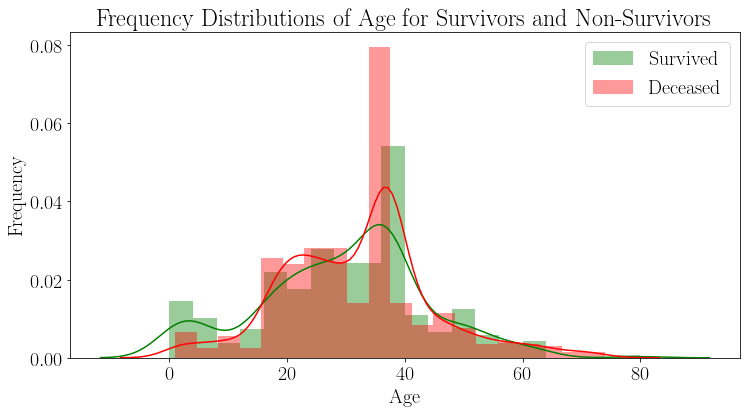

In [70]:
age_survived = df.loc[(df['Age'].notnull()) & (df['Survived'] == 1)][['Survived', 'Age']]

age_died = df.loc[(df['Age'].notnull()) & (df['Survived'] == 0)][['Survived', 'Age']]

plt.figure(figsize = (12, 6))
sns.distplot(age_survived['Age'], bins = 20, label = 'Survived', norm_hist = True, color = 'g')
sns.distplot(age_died['Age'], bins = 20, label = 'Deceased', norm_hist = True, color = 'r')
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Frequency Distributions of Age for Survivors and Non-Survivors")
plt.legend()
plt.savefig('age_freq.png')
plt.show()

In [18]:
stats.pointbiserialr(x = df['Survived'], y = df['Age'])[0] * 100

-8.825551981921839

In [19]:
print("Min age: ", df.Age.min(), "Max age: ", df.Age.max(), "Median age: ", df.Age.median())

Min age:  0 Max age:  80 Median age:  32.0


In [20]:
df.groupby('Survived')['Age'].agg(['min', 'max', 'count', 'mean', 'median', 'std'])

,min,max,count,mean,median,std
Survived,,,,,,
0,1,74,549,32.061931,34,12.731642
1,0,80,342,29.643275,31,14.142600


### FamSize

In [21]:
#calculating family size
df['FamSize'] = df['SibSp'] + df['Parch']

df.drop(['Parch', 'SibSp'], axis = 1, inplace = True)

df.head(n = 5)

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,FamSize
0,1,0,3,0,0,22,A/5 21171,7.2500,NaN,S,1
1,2,1,1,1,1,38,PC 17599,71.2833,C85,C,1
2,3,1,3,2,1,26,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,1,1,35,113803,53.1000,C123,S,1
4,5,0,3,0,0,35,373450,8.0500,NaN,S,0


In [22]:
print(df['FamSize'].min(), df['FamSize'].max())

0 10


In [23]:
df[['FamSize', 'Survived']].corr(method = 'spearman')

,FamSize,Survived
FamSize,1.000000,0.165463
Survived,0.165463,1.000000


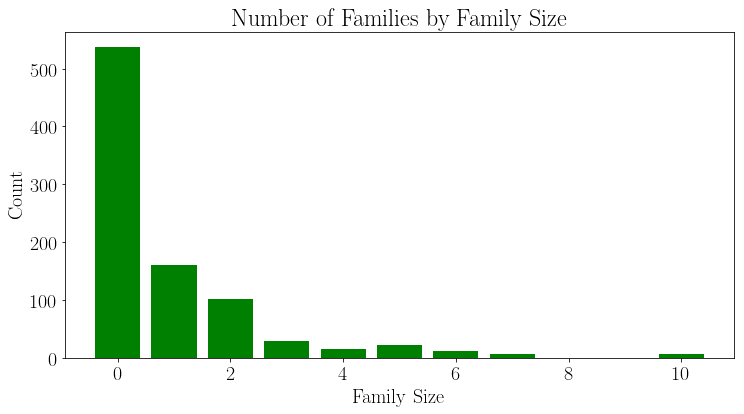

In [71]:
# fam_size = pd.DataFrame(df.FamSize.value_counts())

plt.figure(figsize = (12, 6))
plt.bar(fam_size.index, fam_size['FamSize'], color = 'g')
plt.xlabel('Family Size')
plt.ylabel('Count')
plt.title('Number of Families by Family Size')
plt.savefig('famsize.png')
plt.show()

In [25]:
fam = df.groupby('FamSize')['Survived'].agg(['mean']) * 100

fam

,mean
FamSize,
0,30.353818
1,55.279503
2,57.843137
3,72.413793
4,20.000000
5,13.636364
6,33.333333
7,0.000000
10,0.000000


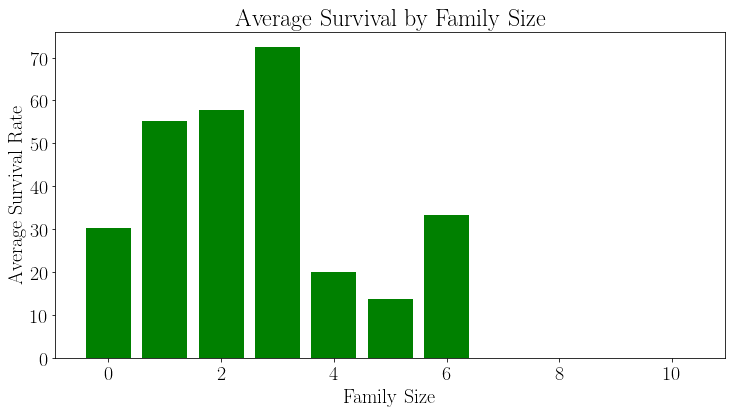

In [72]:
plt.figure(figsize = (12, 6))
plt.bar(fam.index, fam['mean'], color = 'g')
plt.xlabel('Family Size')
plt.ylabel('Average Survival Rate')
plt.title('Average Survival by Family Size')
plt.savefig('famsize_survival.png')
plt.show()

### TicketCount

In [27]:
#counting the number of matching ticket names per passenger as a proxy for family/group size
ticks = pd.DataFrame(df['Ticket'].value_counts()).reset_index(
    
    drop = False).rename(columns={'Ticket': 'TicketCount', 'index': 'Ticket'})

df = df.merge(right = ticks, how = 'left', left_on = 'Ticket', right_on = 'Ticket')

df.drop('Ticket', axis = 1, inplace = True)

df.head(n = 5)

,PassengerId,Survived,Pclass,Name,Sex,Age,Fare,Cabin,Embarked,FamSize,TicketCount
0,1,0,3,0,0,22,7.2500,NaN,S,1,1
1,2,1,1,1,1,38,71.2833,C85,C,1,1
2,3,1,3,2,1,26,7.9250,NaN,S,0,1
3,4,1,1,1,1,35,53.1000,C123,S,1,2
4,5,0,3,0,0,35,8.0500,NaN,S,0,1


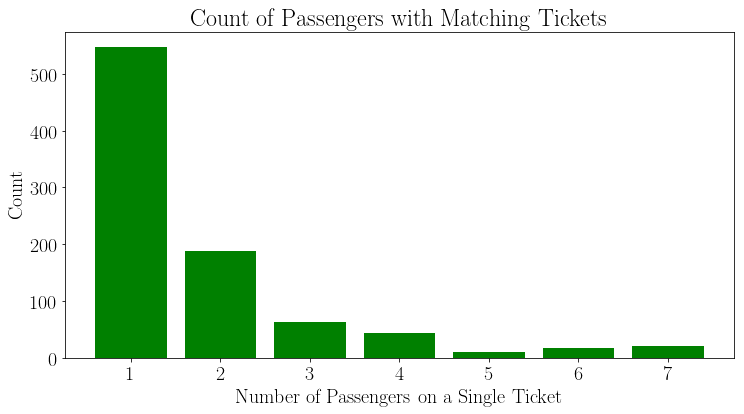

In [73]:
# tix_count = pd.DataFrame(df['TicketCount'].value_counts())

plt.figure(figsize = (12, 6))
plt.bar(tix_count.index, tix_count['TicketCount'], color = 'g')
plt.xlabel('Number of Passengers on a Single Ticket')
plt.ylabel('Count')
plt.title('Count of Passengers with Matching Tickets')
plt.savefig('matching_tix_count.png')
plt.show()

In [29]:
df[['Survived', 'TicketCount']].corr(method = 'spearman')

,Survived,TicketCount
Survived,1.000000,0.181459
TicketCount,0.181459,1.000000


In [30]:
tix = df.groupby('TicketCount')['Survived'].agg(['count', 'mean']) * 100

tix

,count,mean
TicketCount,,
1,54700,29.798903
2,18800,57.446809
3,6300,69.841270
4,4400,50.000000
5,1000,0.000000
6,1800,0.000000
7,2100,23.809524


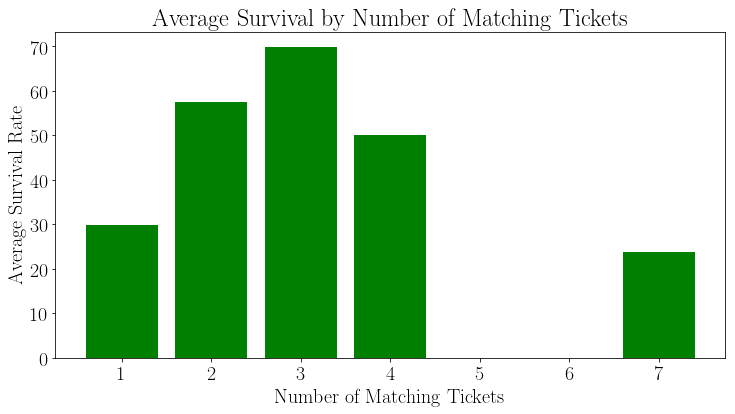

In [74]:
plt.figure(figsize = (12, 6))
plt.bar(tix.index, tix['mean'], color = 'g')
plt.xlabel('Number of Matching Tickets')
plt.ylabel('Average Survival Rate')
plt.title('Average Survival by Number of Matching Tickets')
plt.savefig('tickets.png')
plt.show()

### Fare

In [32]:
print(df.Fare.min(), df.Fare.max(), df.Fare.median(), df.Fare.mean())

0.0 512.3292 14.4542 32.2042079685746


In [33]:
df['Fare'] = np.log(df['Fare'] + 1)

df.head(n = 5)

,PassengerId,Survived,Pclass,Name,Sex,Age,Fare,Cabin,Embarked,FamSize,TicketCount
0,1,0,3,0,0,22,2.110213,NaN,S,1,1
1,2,1,1,1,1,38,4.280593,C85,C,1,1
2,3,1,3,2,1,26,2.188856,NaN,S,0,1
3,4,1,1,1,1,35,3.990834,C123,S,1,2
4,5,0,3,0,0,35,2.202765,NaN,S,0,1


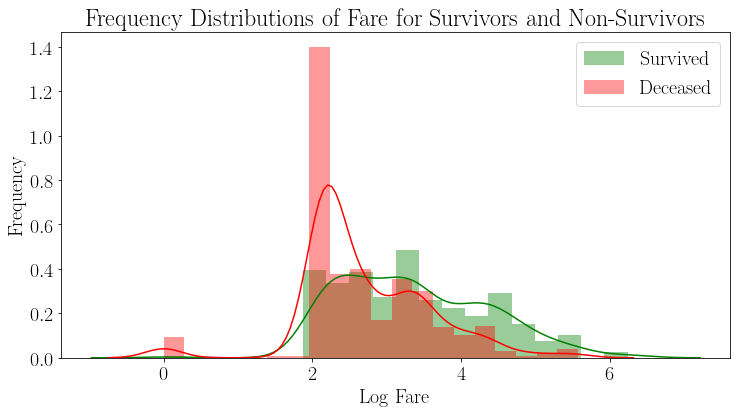

In [76]:
# fare_survived = df.loc[(df['Fare'].notnull()) & (df['Survived'] == 1)][['Survived', 'Fare']]

# fare_died = df.loc[(df['Fare'].notnull()) & (df['Survived'] == 0)][['Survived', 'Fare']]

plt.figure(figsize = (12, 6))
sns.distplot(fare_survived['Fare'], bins = 20, label = 'Survived', norm_hist = True, color = 'g')
sns.distplot(fare_died['Fare'], bins = 20, label = 'Deceased', norm_hist = True, color = 'r')
plt.xlabel("Log Fare")
plt.ylabel("Frequency")
plt.title("Frequency Distributions of Fare for Survivors and Non-Survivors")
plt.legend()
plt.savefig('faree_freq.png')
plt.show()

In [35]:
#relatively high correlation between survival and fare
stats.pointbiserialr(x = df['Survived'], y = df['Fare'])[0] * 100

32.986212869680735

In [36]:
df.groupby('Survived')['Fare'].agg(['mean', 'median'])

,mean,median
Survived,,
0,2.710095,2.442347
1,3.367015,3.295837


### NullCabin

In [37]:
len(df[df['Cabin'].isnull()]) / len(df)

0.7710437710437711

In [38]:
#one-hot encoding Cabin based on null values. null values receive the treatment, specifically.
df['Cabin'] = np.where(df['Cabin'].isnull(), 1, 0)

df.rename(columns = {'Cabin': 'NullCabin'}, inplace = True)

df.head(n = 5)

,PassengerId,Survived,Pclass,Name,Sex,Age,Fare,NullCabin,Embarked,FamSize,TicketCount
0,1,0,3,0,0,22,2.110213,1,S,1,1
1,2,1,1,1,1,38,4.280593,0,C,1,1
2,3,1,3,2,1,26,2.188856,1,S,0,1
3,4,1,1,1,1,35,3.990834,0,S,1,2
4,5,0,3,0,0,35,2.202765,1,S,0,1


In [39]:
df[['NullCabin', 'Survived']].corr(method = 'spearman')

,NullCabin,Survived
NullCabin,1.000000,-0.316912
Survived,-0.316912,1.000000


In [40]:
df.groupby('NullCabin')['Survived'].mean()

NullCabin
0    0.666667
1    0.299854
Name: Survived, dtype: float64

### Embarked

In [41]:
df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [42]:
df.groupby('Embarked')['Survived'].mean()

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

In [43]:
#assigning numeric features to Embarked
df['Embarked'] = np.where(df['Embarked'] == 'S', 1, 
                          
                          np.where(df['Embarked'] == 'C', 2, 
                                   
                                   np.where(df['Embarked'] == 'Q', 3, 1)))

df.head(n = 5)

,PassengerId,Survived,Pclass,Name,Sex,Age,Fare,NullCabin,Embarked,FamSize,TicketCount
0,1,0,3,0,0,22,2.110213,1,1,1,1
1,2,1,1,1,1,38,4.280593,0,2,1,1
2,3,1,3,2,1,26,2.188856,1,1,0,1
3,4,1,1,1,1,35,3.990834,0,1,1,2
4,5,0,3,0,0,35,2.202765,1,1,0,1


In [44]:
df[['Embarked', 'Survived']].corr(method = 'spearman')

,Embarked,Survived
Embarked,1.000000,0.135861
Survived,0.135861,1.000000


## Data Analysis

In [45]:
df[df.columns[1:]].corr(method = 'spearman')

,Survived,Pclass,Name,Sex,Age,Fare,NullCabin,Embarked,FamSize,TicketCount
Survived,1.000000,-0.339668,0.494252,0.543351,-0.073237,0.323736,-0.316912,0.135861,0.165463,0.181459
Pclass,-0.339668,1.000000,-0.125815,-0.135775,-0.244787,-0.688032,0.683291,-0.004962,-0.075698,-0.162688
Name,0.494252,-0.125815,1.000000,0.738122,-0.216537,0.306125,-0.119631,0.124134,0.381261,0.353276
Sex,0.543351,-0.135775,0.738122,1.000000,-0.078743,0.259593,-0.140391,0.120400,0.292035,0.261473
Age,-0.073237,-0.244787,-0.216537,-0.078743,1.000000,0.067423,-0.178848,0.097258,-0.203124,-0.163167
Fare,0.323736,-0.688032,0.306125,0.259593,0.067423,1.000000,-0.539300,-0.010172,0.528907,0.627871
NullCabin,-0.316912,0.683291,-0.119631,-0.140391,-0.178848,-0.539300,1.000000,-0.069204,-0.109296,-0.161583
Embarked,0.135861,-0.004962,0.124134,0.120400,0.097258,-0.010172,-0.069204,1.000000,-0.020141,-0.013004
FamSize,0.165463,-0.075698,0.381261,0.292035,-0.203124,0.528907,-0.109296,-0.020141,1.000000,0.661811
TicketCount,0.181459,-0.162688,0.353276,0.261473,-0.163167,0.627871,-0.161583,-0.013004,0.661811,1.000000


In [46]:
df.groupby('Pclass')['Survived'].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

In [47]:
df.groupby(['Pclass', 'Sex'])['Survived', 'Age'].mean()

Survived        Age
Pclass Sex                     
1      0    0.368852  40.532787
       1    0.968085  34.840426
2      0    0.157407  31.231481
       1    0.921053  28.934211
3      0    0.135447  29.331412
       1    0.500000  26.180556

## Modeling

In [48]:
#assigning dependent and independent features to unique dataframes
X = df[df.columns[2:]].values

y = df['Survived']

In [49]:
#selecting training and testing data with an 85/15 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .15)

k = StratifiedKFold(n_splits = 3, shuffle = True)

In [50]:
#setting parameters for hyperparameter tuning
rfc_params = {
    
    'criterion': ['entropy'],
              
    'n_estimators': [i * 100 for i in range(1, 50)],
              
    'max_features': [i * .05 for i in range(1, 20)],
              
    'max_depth': [i + 1 for i in range(1, 20)],
              
    'min_samples_leaf': [i for i in range(1, 20)],
              
    'bootstrap': ['True'],
              
    'min_samples_split': [i for i in range(2, 20)],
             
    'max_leaf_nodes': [i for i in range(2, 20)]

}

rfc = RandomizedSearchCV(
    
    estimator = RandomForestClassifier(), 
                         
    param_distributions = rfc_params, 
                         
    n_iter = 200, 
                         
    cv = k, 
                        
    scoring = 'accuracy', 
                         
    n_jobs = -1,
    
    iid = False

)

In [51]:
#running randomized cv and saving best estimator
rfc.fit(X_train, y_train)

rfc_best = rfc.best_estimator_

In [52]:
print(rfc.best_estimator_)

RandomForestClassifier(bootstrap='True', class_weight=None,
            criterion='entropy', max_depth=9, max_features=0.55,
            max_leaf_nodes=10, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=9, min_weight_fraction_leaf=0.0,
            n_estimators=1900, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)


### Results

In [53]:
print("Accuracy score using best estimator to predict survival for test set: ", rfc_best.score(X_test, y_test) * 100)

Accuracy score using best estimator to predict survival for test set:  85.07462686567165


In [54]:
#calculating learning curves based on model best estimators
train_sizes, train_scores, test_scores = learning_curve(
    
    estimator = rfc_best, 
                                                        
    X = X_train, 
                                                        
    y = y_train, 
                                                        
    cv = k, 
                                                        
    n_jobs = -1,
                                                        
    train_sizes = [i * .1 for i in range(1, 10)]

)

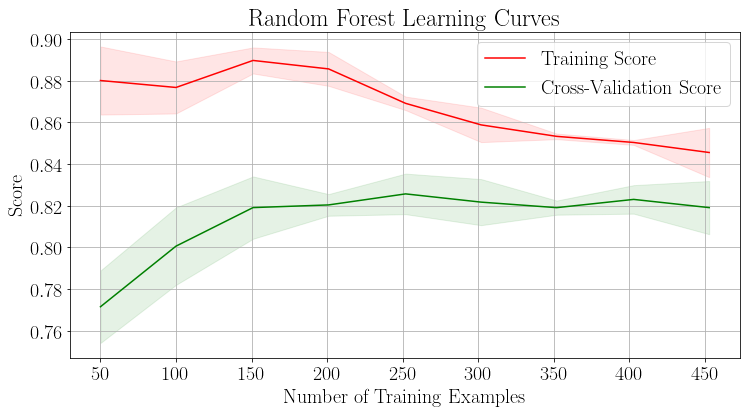

In [77]:
#plotting learning curves
train_scores_mean = np.mean(train_scores, axis = 1)

train_scores_std = np.std(train_scores, axis = 1)

test_scores_mean = np.mean(test_scores, axis = 1)

test_scores_std = np.std(test_scores, axis = 1)

plt.figure(figsize = (12, 6))

plt.plot(
    
    train_sizes, 
    
    train_scores_mean, 
    
    label = 'Training Score', 
    
    color = 'r'

)

plt.fill_between(
    
    train_sizes, 
    
    train_scores_mean - train_scores_std, 
                 
    train_scores_mean + train_scores_std, 
    
    alpha = 0.1, 
    
    color = 'r'

)

plt.plot(
    
    train_sizes, 
    
    test_scores_mean, 
    
    label = 'Cross-Validation Score', 
    
    color = 'g'

)

plt.fill_between(
    
    train_sizes, 
    
    test_scores_mean - test_scores_std,
                 
    test_scores_mean + test_scores_std, 
    
    alpha = 0.1, 
    
    color = 'g'

)

plt.ylabel('Score')

plt.xlabel('Number of Training Examples')

plt.title("Random Forest Learning Curves")

plt.legend(loc = 'best')

plt.grid()

plt.savefig('learningcurve.png')

plt.show()

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


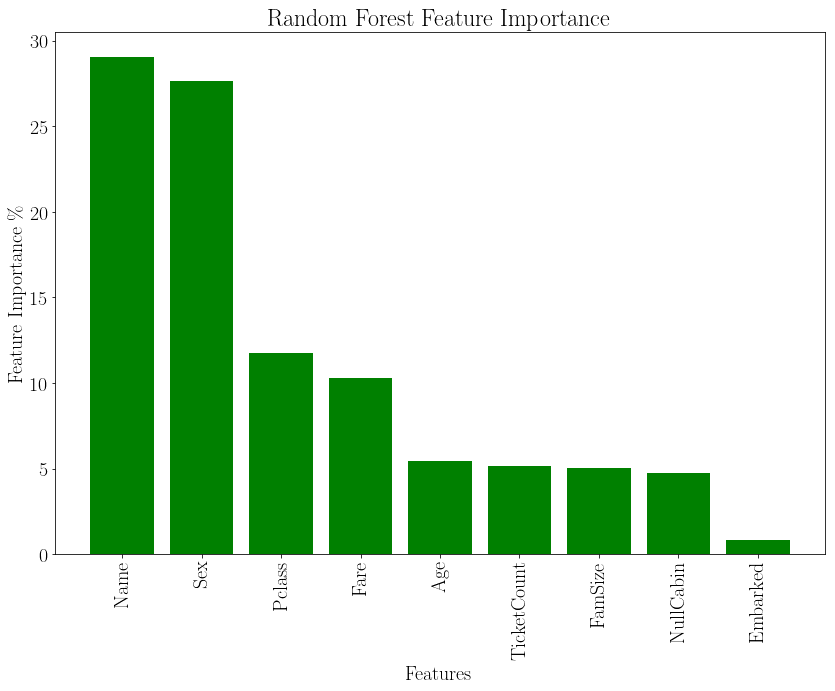

In [85]:
feature_importance = pd.DataFrame(
    
    data = rfc_best.feature_importances_ * 100, 
    
    columns = ['FeatureImportance'], 
    
    index = df.columns[2:]

).sort_values(by = 'FeatureImportance', ascending = False)

plt.figure(figsize = (12, 10))

plt.bar(feature_importance.index, feature_importance['FeatureImportance'], color = 'g')

plt.title('Random Forest Feature Importance')

plt.ylabel('Feature Importance \%')

plt.xlabel('Features')

plt.xticks(rotation = 'vertical')

plt.savefig('featureimportance.png')

plt.show()